**Udemy 6-16. Stock Return Predictions using LSTMs (pt 3)**

Note: We will use all of the data: open, high, low, close, and volume (D=5) to binary classification; predict whether the price will go up or down

# Part 3 - Binary Classification


In [194]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [195]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [196]:
URL = "https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/sbux.csv"

# Download the data using the URL
df = pd.read_csv(URL)

In [197]:
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX


In [198]:
df.tail()

,date,open,high,low,close,volume,Name
1254,2018-02-01,56.280,56.42,55.89,56.00,14690146,SBUX
1255,2018-02-02,55.900,56.32,55.70,55.77,15358909,SBUX
1256,2018-02-05,55.530,56.26,54.57,54.69,16059955,SBUX
1257,2018-02-06,53.685,56.06,53.56,55.61,17415065,SBUX
1258,2018-02-07,55.080,55.43,54.44,54.46,13927022,SBUX


In [199]:
# Calculate returns by fist shifting the data
df['prevClose'] = df['close'].shift(1) # move everything up by 1
df.head()

,date,open,high,low,close,volume,Name,prevClose
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915


In [200]:
df['returns'] = (df['close'] - df['prevClose']) / df['prevClose']
df.head()

,date,open,high,low,close,volume,Name,prevClose,returns
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185,-0.004080
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070,0.002138
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130,-0.007643
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915,-0.005015


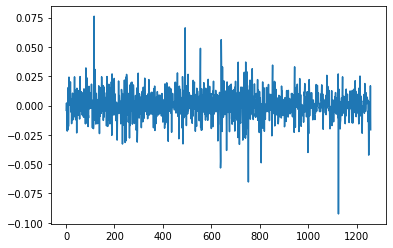

In [201]:
plt.plot(df['returns']);

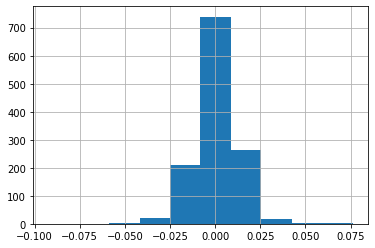

In [202]:
df['returns'].hist()

In [203]:
# Now turn the full data into numpy array
input_data = df[['open', 'high', 'low', 'close', 'volume']].values[1:] # Not yet in the right "X" format
targets = df['returns'].values[1:]

In [204]:
# Now make the actual data which will go into the neural network
T = 10 # the number of steps to look at to predict the next step
D = input_data.shape[1] 
N = len(input_data) - T # number of samples: e.g. if you have 11 data point and T=10 then you will have only N=1 sample

In [205]:
# Normalize the inputs
Ntrain = len(input_data) * 2 // 3
scaler = StandardScaler()
scaler.fit(input_data[:Ntrain + T - 1]) # Note as the "volume" data is too big it is necessary to scalethe data
input_data = scaler.transform(input_data)

In [206]:
# Setup X_train and Y_train
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros((Ntrain, 1))

for t in range(Ntrain):
  X_train[t,:,:] = input_data[t:t+T]
  Y_train[t] = (targets[t+T] > 0)


# Setup X_test and Y_test
X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros((N - Ntrain, 1))

for u in range(N - Ntrain):
  # u counts from 0 ... (N - Ntrain)
  # t counts from Ntrain ... N
  t = u + Ntrain
  X_test[u,:,:] = input_data[t:t+T]
  Y_test[u] = (targets[t+T] > 0)


In [207]:
# Define the model
class RNN(nn.Module):
  def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
    super().__init__()
    self.D = n_inputs
    self.M = n_hidden
    self.K = n_outputs
    self.L = n_rnnlayers

    self.lstm = nn.LSTM(
        input_size=self.D,
        hidden_size=self.M,
        num_layers=self.L,
        batch_first=True)
    
    self.fc = nn.Linear(in_features=self.M, out_features=self.K)

  def forward(self, X):
    # LSTM layer
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    c0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    out, _ = self.lstm(X, (h0, c0))

    # Dense layer
    # We only want h(T) at the final step
    out = self.fc(out[:,-1,:])
    
    return out

In [208]:
model = RNN(n_inputs=5, n_hidden=50, n_rnnlayers=2, n_outputs=1)
model.to(device)

RNN(
  (lstm): LSTM(5, 50, num_layers=2, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [209]:
# Loss and Optimizer - Now it's classification
criterion = nn.BCEWithLogitsLoss() # Binary Cross Entropy 
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [210]:
# Make inputs and outputs target
X_train = torch.from_numpy(X_train.astype(np.float32))
y_train = torch.from_numpy(Y_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_test = torch.from_numpy(Y_test.astype(np.float32))

# Move data to GPU
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [211]:
# Training
def full_gd(model, criterion, optimizer, X_train, y_train, X_test, y_test, epochs=200):
    # Stuff to store
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    
    for it in range(epochs):
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        
        # Backward and optimize
        loss.backward()
        optimizer.step()
        
        # Save losses
        train_losses[it] = loss.item()
        
        # Test loss
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses[it] = test_loss.item()
        
        if (it + 1) % 50 == 0:
            print(f"Epoch {it+1}/{epochs}, Train_loss: {train_losses[it]:.4f}, Test_loss: {test_losses[it]:.4f}")
    
    return train_losses, test_losses

In [212]:
train_losses, test_losses = full_gd(model, criterion, optimizer, X_train, y_train, X_test, y_test, epochs=300)

Epoch 50/300, Train_loss: 0.6205, Test_loss: 0.7366
Epoch 100/300, Train_loss: 0.4411, Test_loss: 1.1312
Epoch 150/300, Train_loss: 0.2325, Test_loss: 1.5798
Epoch 200/300, Train_loss: 0.0745, Test_loss: 2.4922
Epoch 250/300, Train_loss: 0.0042, Test_loss: 3.6506
Epoch 300/300, Train_loss: 0.0016, Test_loss: 3.8842


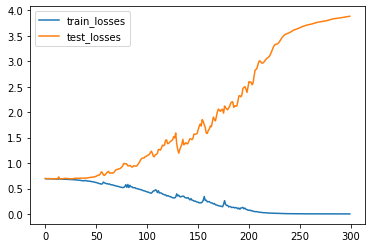

In [213]:
plt.plot(train_losses, label="train_losses")
plt.plot(test_losses, label="test_losses")
plt.legend()
plt.show()

In [215]:
# Get Accuracy
with torch.no_grad():
  p_train = model(X_train)
  p_train = (p_train.cpu().numpy() > 0)
  train_acc = np.mean(y_train.cpu().numpy() == p_train)

  p_test = model(X_test)
  p_test = (p_test.cpu().numpy() > 0)
  test_acc = np.mean(y_test.cpu().numpy() == p_test)

print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

# Note: the worse result for test acc is 0.5; It mean random 


Train acc: 1.0000, Test acc: 0.4683
